In [86]:
# import libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split

In [162]:
initialDf = pd.read_csv("steam.csv")
initialDf.head()

appid                       name release_date  english         developer  \
0     10             Counter-Strike   2000-11-01        1             Valve   
1     20      Team Fortress Classic   1999-04-01        1             Valve   
2     30              Day of Defeat   2003-05-01        1             Valve   
3     40         Deathmatch Classic   2001-06-01        1             Valve   
4     50  Half-Life: Opposing Force   1999-11-01        1  Gearbox Software   

  publisher          platforms  required_age  \
0     Valve  windows;mac;linux             0   
1     Valve  windows;mac;linux             0   
2     Valve  windows;mac;linux             0   
3     Valve  windows;mac;linux             0   
4     Valve  windows;mac;linux             0   

                                          categories  genres  \
0  Multi-player;Online Multi-Player;Local Multi-P...  Action   
1  Multi-player;Online Multi-Player;Local Multi-P...  Action   
2              Multi-player;Valve Anti-Cheat enabled  Action   
3  Multi-player;Online Multi-Player;Local Multi-P...  Action   
4  Single-player;Multi-player;Valve Anti-Cheat en...  Action   

                  steamspy_tags  achievements  positive_ratings  \
0        Action;FPS;Multiplayer             0            124534   
1        Action;FPS;Multiplayer             0              3318   
2  FPS;World War II;Multiplayer             0              3416   
3        Action;FPS;Multiplayer             0              1273   
4             FPS;Action;Sci-fi             0              5250   

   negative_ratings  average_playtime  median_playtime             owners  \
0              3339             17612              317  10000000-20000000   
1               633               277               62   5000000-10000000   
2               398               187               34   5000000-10000000   
3               267               258              184   5000000-10000000   
4               288               624              415   5000000-10000000   

   price  
0   7.19  
1   3.99  
2   3.99  
3   3.99  
4   3.99

In [163]:
for var in initialDf.columns:
    if len(initialDf[var]) != len(initialDf[var].dropna()):
        print(var)
print('Done')
#Check to see if there are any na's

Done


In [164]:
df = pd.DataFrame()
df["Name"] = initialDf["name"].apply(lambda x: str(x))
df["ReleaseYear"] = initialDf["release_date"].apply(lambda x: int(x[0:4]))
df["ReleaseMonth"] = initialDf["release_date"].apply(lambda x: int(x[5:7]))
df["English"] = initialDf["english"].apply(lambda x: int(x))
df["Developer"] = initialDf["developer"].apply(lambda x: str(x))
df["Publisher"] = initialDf["publisher"].apply(lambda x: str(x))
df["Windows"] = initialDf["platforms"].apply(lambda x: bool("windows" in x))
df["Mac"] = initialDf["platforms"].apply(lambda x: bool("mac" in x))
df["Linux"] = initialDf["platforms"].apply(lambda x: bool("linux" in x))
df["RequiredAge"] = initialDf["required_age"].apply(lambda x: int(x))
df["Categories"] = initialDf["categories"].apply(lambda x: str(x))
df["Genre"] = initialDf["genres"].apply(lambda x: str(x))
df["Price"] = initialDf["price"].apply(lambda x: float(x))


#df["PositiveRatings"] = initialDf["positive_ratings"].apply(lambda x: int(x))
#df["NegativeRatings"] = initialDf["negative_ratings"].apply(lambda x: int(x))
df["MedianPlaytime"] = initialDf["median_playtime"].apply(lambda x: str(x))
df["AveragePlaytime"] = initialDf["average_playtime"].apply(lambda x: str(x))
df["LowerOwners"] = initialDf["owners"].apply(lambda x: int(x[:x.find("-")]))
df["UpperOwners"] = initialDf["owners"].apply(lambda x: int(x[x.find("-")+1:]))

In [165]:
initialNormalizeFeatures = ['positive_ratings', 'negative_ratings']
NormalizeFeatures = ['PositiveRatings', 'NegativeRatings']
dfNormalize = pd.DataFrame(data=MinMaxScaler().fit_transform(initialDf[initialNormalizeFeatures]), columns=NormalizeFeatures)

df = pd.concat([df, dfNormalize], axis=1)
df.head()

Name  ReleaseYear  ReleaseMonth  English  \
0             Counter-Strike         2000            11        1   
1      Team Fortress Classic         1999             4        1   
2              Day of Defeat         2003             5        1   
3         Deathmatch Classic         2001             6        1   
4  Half-Life: Opposing Force         1999            11        1   

          Developer Publisher  Windows   Mac  Linux  RequiredAge  \
0             Valve     Valve     True  True   True            0   
1             Valve     Valve     True  True   True            0   
2             Valve     Valve     True  True   True            0   
3             Valve     Valve     True  True   True            0   
4  Gearbox Software     Valve     True  True   True            0   

                                          Categories   Genre  Price  \
0  Multi-player;Online Multi-Player;Local Multi-P...  Action   7.19   
1  Multi-player;Online Multi-Player;Local Multi-P...  Action   3.99   
2              Multi-player;Valve Anti-Cheat enabled  Action   3.99   
3  Multi-player;Online Multi-Player;Local Multi-P...  Action   3.99   
4  Single-player;Multi-player;Valve Anti-Cheat en...  Action   3.99   

  MedianPlaytime AveragePlaytime  LowerOwners  UpperOwners  PositiveRatings  \
0            317           17612     10000000     20000000         0.047093   
1             62             277      5000000     10000000         0.001255   
2             34             187      5000000     10000000         0.001292   
3            184             258      5000000     10000000         0.000481   
4            415             624      5000000     10000000         0.001985   

   NegativeRatings  
0         0.006855  
1         0.001300  
2         0.000817  
3         0.000548  
4         0.000591

In [166]:
df["NegativeRatings"].replace({0: 1}, inplace=True)

In [167]:
df['Pos_over_Neg'] =  (df['PositiveRatings'] / df['NegativeRatings']).apply(lambda x: float(x))

df['Ratio_over_std'] = np.where(df['Pos_over_Neg']>=df['Pos_over_Neg'].std(), 1, 0)

In [168]:
df.describe()

ReleaseYear  ReleaseMonth       English   RequiredAge         Price  \
count  27075.000000  27075.000000  27075.000000  27075.000000  27075.000000   
mean    2016.498098      6.555457      0.981127      0.354903      6.078193   
std        2.156990      3.459959      0.136081      2.406044      7.874922   
min     1997.000000      1.000000      0.000000      0.000000      0.000000   
25%     2016.000000      3.000000      1.000000      0.000000      1.690000   
50%     2017.000000      7.000000      1.000000      0.000000      3.990000   
75%     2018.000000     10.000000      1.000000      0.000000      7.190000   
max     2019.000000     12.000000      1.000000     18.000000    421.990000   

        LowerOwners   UpperOwners  PositiveRatings  NegativeRatings  \
count  2.707500e+04  2.707500e+04     27075.000000     27075.000000   
mean   8.012669e+04  1.880543e+05         0.000378         0.107765   
std    8.708977e+05  1.786801e+06         0.007181         0.309515   
min    0.000000e+00  2.000000e+04         0.000000         0.000002   
25%    0.000000e+00  2.000000e+04         0.000002         0.000008   
50%    0.000000e+00  2.000000e+04         0.000009         0.000033   
75%    2.000000e+04  5.000000e+04         0.000048         0.000220   
max    1.000000e+08  2.000000e+08         1.000000         1.000000   

       Pos_over_Neg  Ratio_over_std  
count  27075.000000    27075.000000  
mean       0.851269        0.149215  
std        1.476571        0.356307  
min        0.000000        0.000000  
25%        0.162503        0.000000  
50%        0.418658        0.000000  
75%        0.959329        0.000000  
max       47.981813        1.000000

In [169]:
df.head()

Name  ReleaseYear  ReleaseMonth  English  \
0             Counter-Strike         2000            11        1   
1      Team Fortress Classic         1999             4        1   
2              Day of Defeat         2003             5        1   
3         Deathmatch Classic         2001             6        1   
4  Half-Life: Opposing Force         1999            11        1   

          Developer Publisher  Windows   Mac  Linux  RequiredAge  ...   Genre  \
0             Valve     Valve     True  True   True            0  ...  Action   
1             Valve     Valve     True  True   True            0  ...  Action   
2             Valve     Valve     True  True   True            0  ...  Action   
3             Valve     Valve     True  True   True            0  ...  Action   
4  Gearbox Software     Valve     True  True   True            0  ...  Action   

  Price  MedianPlaytime AveragePlaytime LowerOwners  UpperOwners  \
0  7.19             317           17612    10000000     20000000   
1  3.99              62             277     5000000     10000000   
2  3.99              34             187     5000000     10000000   
3  3.99             184             258     5000000     10000000   
4  3.99             415             624     5000000     10000000   

   PositiveRatings  NegativeRatings  Pos_over_Neg  Ratio_over_std  
0         0.047093         0.006855      6.869742               1  
1         0.001255         0.001300      0.965476               0  
2         0.001292         0.000817      1.580898               1  
3         0.000481         0.000548      0.878185               0  
4         0.001985         0.000591      3.357652               1  

[5 rows x 21 columns]

In [170]:
def pos_neg(var):
    y = df['Pos_over_Neg']
    x = df[var]
    figure = plt.figure(figsize = (25,7))
    plt.scatter(x, y, marker='o');
    plt.ylabel('(Positive/Negative) Rating')
    plt.xlabel(var)

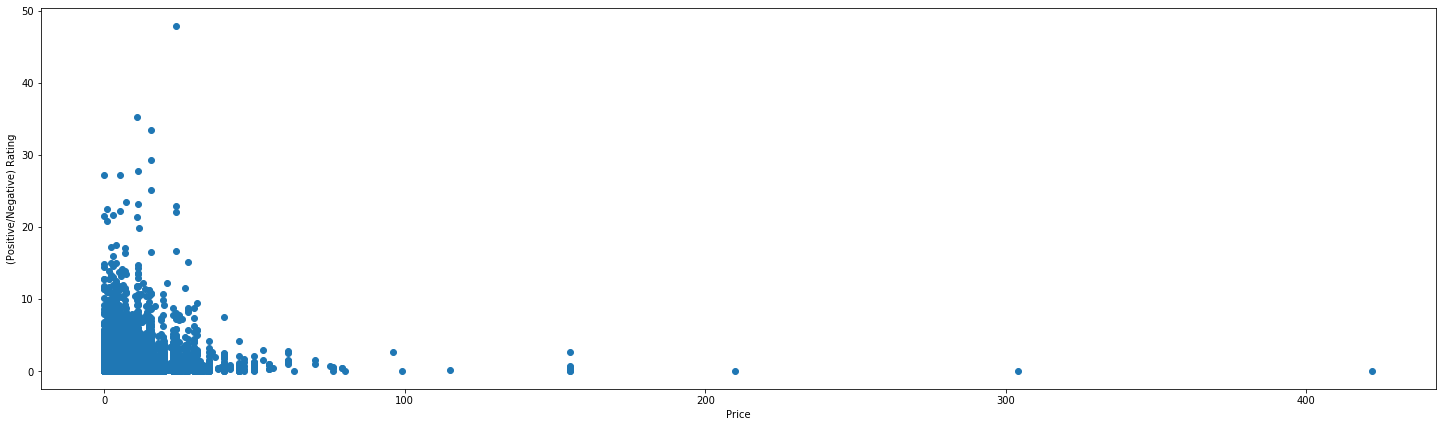

In [171]:
pos_neg("Price")

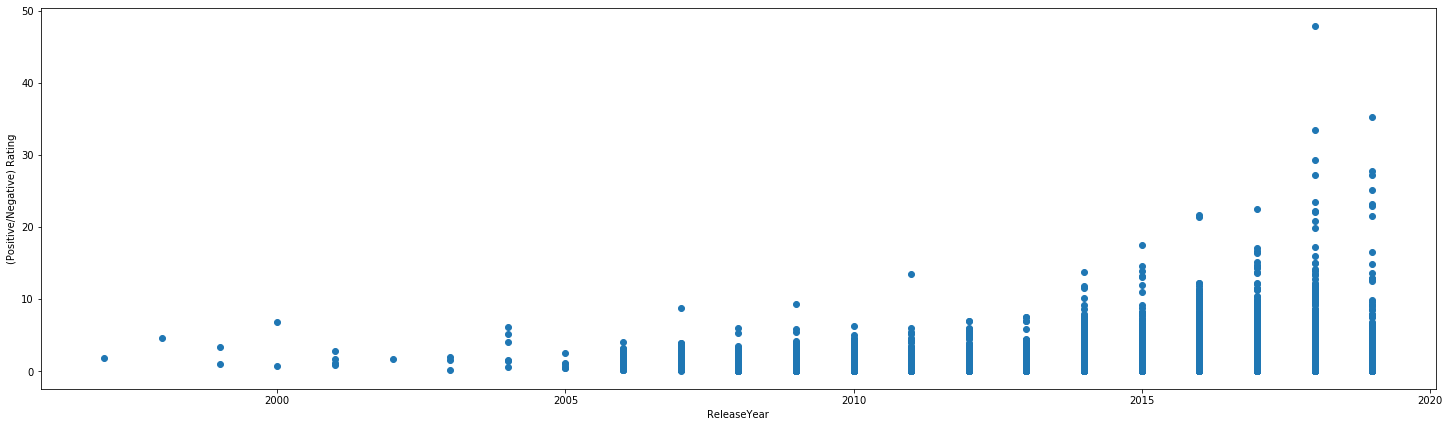

In [172]:
pos_neg("ReleaseYear")

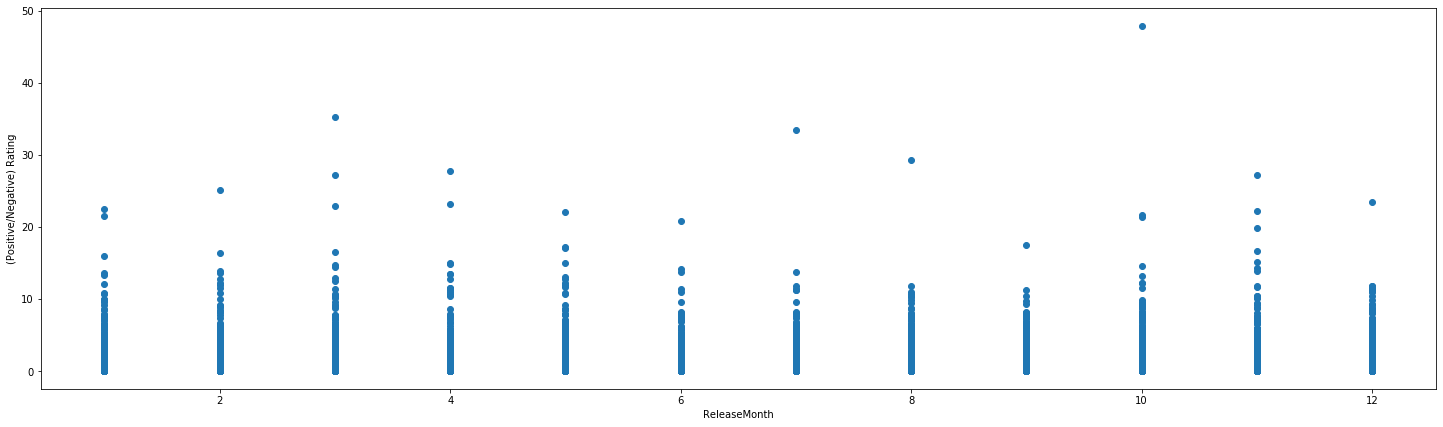

In [173]:
pos_neg("ReleaseMonth")

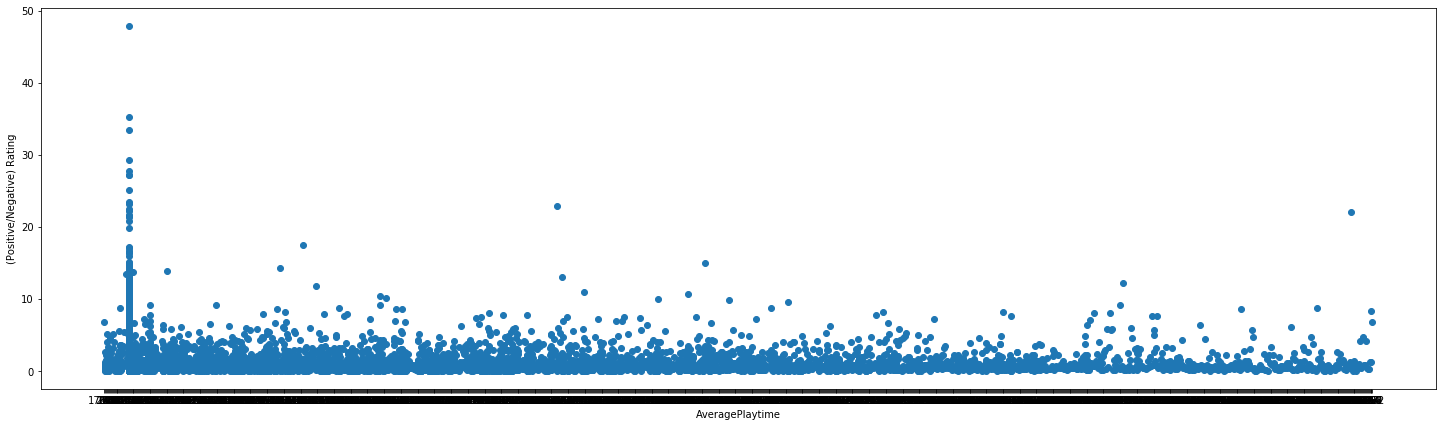

In [174]:
pos_neg("AveragePlaytime")

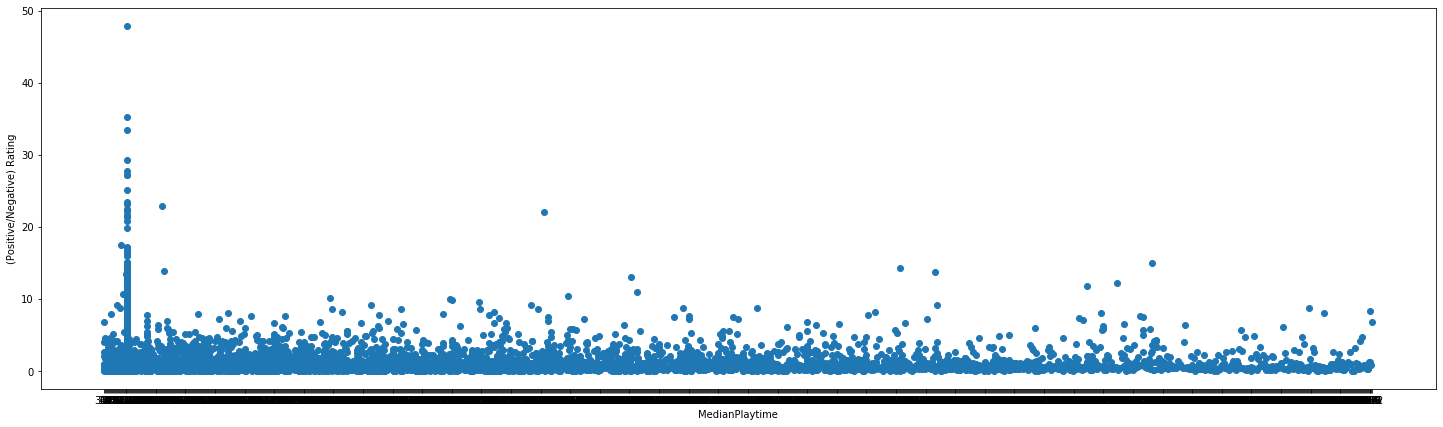

In [175]:
pos_neg("MedianPlaytime")

Text(0, 0.5, '(Positive/Negative) Rating')

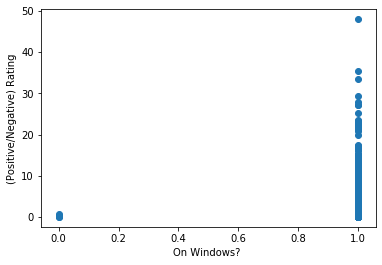

In [176]:
plt.scatter(df.Windows, df["Pos_over_Neg"], label='Widnows')
plt.xlabel('On Windows? ')
plt.ylabel('(Positive/Negative) Rating')

Text(0, 0.5, '(Positive/Negative) Rating')

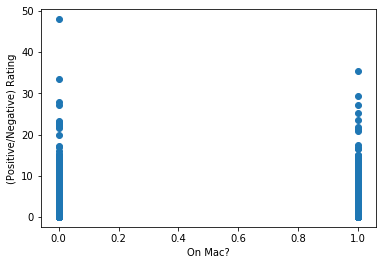

In [177]:
plt.scatter(df.Mac, df["Pos_over_Neg"], label='Mac')
plt.xlabel('On Mac?')
plt.ylabel('(Positive/Negative) Rating')

Text(0, 0.5, '(Positive/Negative) Rating')

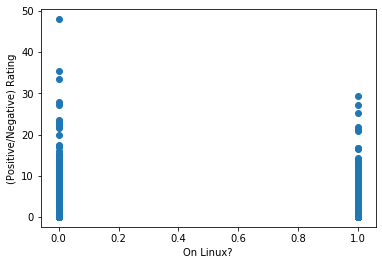

In [178]:
plt.scatter(df.Linux, df["Pos_over_Neg"], label='Linux')
plt.xlabel('On Linux?')
plt.ylabel('(Positive/Negative) Rating')

In [179]:
print(df.columns)

Index(['Name', 'ReleaseYear', 'ReleaseMonth', 'English', 'Developer',
       'Publisher', 'Windows', 'Mac', 'Linux', 'RequiredAge', 'Categories',
       'Genre', 'Price', 'MedianPlaytime', 'AveragePlaytime', 'LowerOwners',
       'UpperOwners', 'PositiveRatings', 'NegativeRatings', 'Pos_over_Neg',
       'Ratio_over_std'],
      dtype='object')


In [236]:
features = ['ReleaseYear', 'ReleaseMonth', 'English', 'Windows', 'Mac', 'Linux', 'RequiredAge', 'Price']
target = 'Ratio_over_std'

In [237]:
tensor = tf.constant(df[features].values)

In [238]:
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].apply(lambda x: int(1 if x else 0))
#for col in df.select_dtypes(include=['int']).columns:
#    df[col] = df[col].apply(lambda x: float(x))
df.head()

Name  ReleaseYear  ReleaseMonth  English  \
0             Counter-Strike         2000            11        1   
1      Team Fortress Classic         1999             4        1   
2              Day of Defeat         2003             5        1   
3         Deathmatch Classic         2001             6        1   
4  Half-Life: Opposing Force         1999            11        1   

          Developer Publisher  Windows  Mac  Linux  RequiredAge  ...   Genre  \
0             Valve     Valve        1    1      1            0  ...  Action   
1             Valve     Valve        1    1      1            0  ...  Action   
2             Valve     Valve        1    1      1            0  ...  Action   
3             Valve     Valve        1    1      1            0  ...  Action   
4  Gearbox Software     Valve        1    1      1            0  ...  Action   

  Price  MedianPlaytime AveragePlaytime LowerOwners  UpperOwners  \
0  7.19             317           17612    10000000     20000000   
1  3.99              62             277     5000000     10000000   
2  3.99              34             187     5000000     10000000   
3  3.99             184             258     5000000     10000000   
4  3.99             415             624     5000000     10000000   

   PositiveRatings  NegativeRatings  Pos_over_Neg  Ratio_over_std  
0         0.047093         0.006855      6.869742               1  
1         0.001255         0.001300      0.965476               0  
2         0.001292         0.000817      1.580898               1  
3         0.000481         0.000548      0.878185               0  
4         0.001985         0.000591      3.357652               1  

[5 rows x 21 columns]

In [239]:
lenTrain, lenVal = 25000, 1000
train, test = train_test_split(df, test_size=len(df)-lenTrain-lenVal)
train, val = train_test_split(train, test_size=lenVal)

In [240]:
X_train, X_val, X_test = train[features], val[features], test[features]
y_train, y_val, y_test = train[target], val[target], test[target]
print(X_train)

       ReleaseYear  ReleaseMonth  English  Windows  Mac  Linux  RequiredAge  \
16695         2017            10        1        1    1      1            0   
18128         2019             3        1        1    1      1            0   
13985         2017            10        1        1    0      0           18   
7582          2016             3        1        1    0      0            0   
20711         2018             4        1        1    0      0            0   
...            ...           ...      ...      ...  ...    ...          ...   
23592         2018             7        1        1    0      0            0   
24677         2018            11        1        1    0      0            0   
10633         2017             9        1        1    0      0            0   
26026         2019             2        1        1    0      0            0   
14403         2018             4        1        1    0      0            0   

       Price  
16695   3.99  
18128  15.49  
13985 

In [241]:
X_train = tf.constant(X_train.values)
X_val = tf.constant(X_val.values)
X_test = tf.constant(X_test.values)

y_train=tf.constant(y_train.values)
y_val=tf.constant(y_val.values)
y_test=tf.constant(y_test.values)

In [242]:
hu1 = 9
hu2 = 4
afunc = tf.nn.relu

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(hu1, activation=afunc))
#model.add(tf.keras.layers.Dense(hu2, activation=afunc))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

In [243]:
optim = 'adam'
model.compile(optimizer=optim,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [244]:
model.fit(X_train, y_train, epochs=50, batch_size=1000)

Train on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 2s 75us/sample - loss: 79.0913 - binary_accuracy: 0.8507
Epoch 2/50
25000/25000 [==============================] - 0s 1us/sample - loss: 69.0800 - binary_accuracy: 0.8507
Epoch 3/50
25000/25000 [==============================] - 0s 1us/sample - loss: 61.8875 - binary_accuracy: 0.8507
Epoch 4/50
25000/25000 [==============================] - 0s 1us/sample - loss: 55.6226 - binary_accuracy: 0.8507
Epoch 5/50
25000/25000 [==============================] - 0s 1us/sample - loss: 49.8408 - binary_accuracy: 0.8507
Epoch 6/50
25000/25000 [==============================] - 0s 1us/sample - loss: 44.5298 - binary_accuracy: 0.8507
Epoch 7/50
25000/25000 [==============================] - 0s 1us/sample - loss: 39.6785 - binary_accuracy: 0.8507
Epoch 8/50
25000/25000 [==============================] - 0s 1us/sample - loss: 35.2061 - binary_accuracy: 0.8507
Epoch 9/50
25000/25000 [==============================] - 0s 1us

In [245]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(val_loss)
print(val_acc)

1000/1000 [==============================] - 0s 133us/sample - loss: 0.4284 - binary_accuracy: 0.8450
0.42841129446029663
0.845


In [246]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss)
print(val_acc)

1075/1075 [==============================] - 0s 30us/sample - loss: 0.4107 - binary_accuracy: 0.8567
0.41069996198942493
0.85674417
